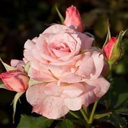

In [9]:
import torch
import numpy as np
from PIL import Image
from typing import Any

im = Image.open('rose_crop.jpg')
im_small = im.resize((128, 128))
im_small

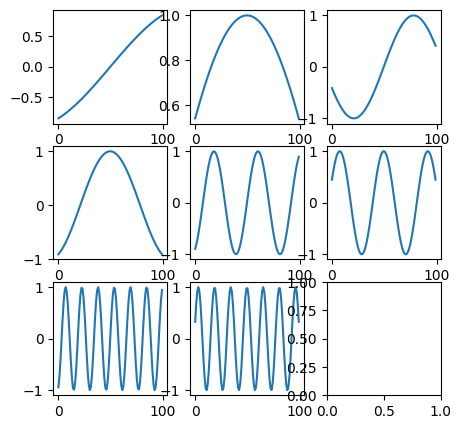

In [24]:
from matplotlib import pyplot as plt

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.freq = torch.exp(torch.arange(0, embed_dim, 2).float() / 2)

    def forward(self, x) -> Any:
        x = x[..., None, :] * self.freq[..., None].to(x.device)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1).view(*x.shape[:-2], -1)

f, ax = plt.subplots(3, 3, figsize=(5, 5))

pe = PositionalEmbedding(8)
e = pe(torch.linspace(-1, 1, 100)[:, None])
for i in range(8):
    ax[i // 3, i % 3].plot(e[:, i].numpy())

0.3375105857849121
0.06793618947267532
0.04243267700076103
0.0329483263194561
0.029384776949882507
0.027513956651091576
0.02544412761926651
0.02249622344970703
0.02153942920267582
0.020018914714455605
0.0199743565171957
0.019322874024510384
0.019451379776000977
0.01784912496805191
0.01860780268907547
0.01796453632414341
0.018740534782409668
0.01704568602144718
0.015714796259999275
0.01583373360335827
0.014275945723056793
0.016716348007321358
0.014347217977046967
0.01506472285836935
0.015996305271983147
0.014200352132320404
0.013135929591953754
0.013291423209011555
0.01397442352026701
0.013502657413482666
0.013371449895203114
0.01355609018355608
0.013278315775096416
0.013603225350379944
0.013422638177871704
0.011286094784736633
0.012360624969005585
0.011850818991661072
0.011612560600042343
0.011765924282371998
0.012960965745151043
0.013744394294917583
0.012092138640582561
0.012190678156912327
0.011965830810368061
0.011186112649738789
0.012909275479614735
0.011728107929229736
0.010737224

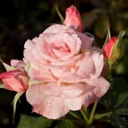

In [25]:
class Rose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = PositionalEmbedding(12)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(24, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

    def forward(self, x):
        return self.net(self.enc(x))

rose_tensor = torch.as_tensor(np.array(im_small), dtype=torch.float32) / 255. - 0.5
position = torch.stack(torch.meshgrid(torch.linspace(-1, 1, 128), torch.linspace(-1, 1, 128)), dim=-1)

net = Rose()

if torch.cuda.is_available():
    rose_tensor = rose_tensor.cuda()
    position = position.cuda()
    net.cuda()

optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for it in range(5000):
    optim.zero_grad()
    loss = abs(net(position) - rose_tensor).mean()
    if it % 100 == 0:
        print(float(loss))
    loss.backward()
    optim.step()

Image.fromarray(((net(position) + 0.5).clamp(0, 1) * 255).cpu().to(torch.uint8).numpy())